In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# установка стиля matplotlib
%matplotlib inline
# plt.style.use('ggplot')

# доступные стили отображения графика в matplotlib
# plt.style.available

# библиотека для расчетов метрик
from scipy import stats
from sklearn import metrics

# библиотека для нормализации, стандартизации
from sklearn import preprocessing

# библиотека модели кластеризации
from sklearn import cluster

# библиотека для разделения датасета
from sklearn import model_selection

# библиотека для исключения признаков RFE
from sklearn import feature_selection

# библиотека для кодирования признаков
# import category_encoders as ce

# для обработки timestamp в формате utc
import datetime, time

# работа с json
# import json
from pprint import pprint

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# логгирование / логирование
import logging

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# библиотека для передачи функции обратного вызова
# from functools import partial

# библиотека поиска гиперпараметров hyperopt
# import hyperopt
# from hyperopt import hp, fmin, tpe, Trials

# библиотека поиска гиперпараметров optuna
# import optuna
# from optuna import Trial, study, samplers

# подключить сборщик "мусора"
import gc

# импорт collections для работы с упорядоченным словарём
from collections import OrderedDict

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.large_repr', 'truncate')

# увеличить вывод количества отображаемых колонок
pd.set_option('display.max_columns', 40)

In [2]:
# ускоряем вычисления pandas'а векторными преобразованиями
import swifter

from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler='threads',
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False,
)

# КОНСТАНТЫ
SRC_SUBFOLDER = './.'

# формируем относительный системный путь для импорта файлов с функциями
# если SRC_SUBFOLDER = './.' + './', получим относительный путь './../'
sys.path.append(os.path.relpath(SRC_SUBFOLDER + './'))

# импортируем внешние константы
from src.constants import *

# импортируем собственные функции
from src.funcs_1 import *
from src.funcs_2 import *
from src.funcs_3 import *
from src.funcs_4 import *

## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Прочитаем наш файл с исходными данными:

In [3]:
# задаём переменные для выгрузки датасета
taxi_data_file = DATA_SUBFOLDER + './data/train.csv'
taxi_data_url = 'https://drive.google.com/file/d/1X_EJEfERiXki0SKtbnCL9JDv49Go14lF/view?usp=sharing'

# загружаем датасет
taxi_data = get_dataset(taxi_data_file, taxi_data_url, 'g', ',')

# выводим результат
print(f'Размер датафрейма: {taxi_data.shape}')
taxi_data.head()

Размер датафрейма: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

---

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
# делаем копию данных
df = taxi_data.copy()

In [5]:
# применяем преобразования с помощью функции
df = modify_data_types(df)

# понижаем размерность признаков по типу занимаемых данных
df['trip_duration'] = df['trip_duration'].astype('int32')

# преобразуем признаки в формат datetime
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

# выводим результат
df.info()

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
dtypes: datetime64[ns](2), float32(4), int32(1), int8(3), object(1)
memory usage: 65.4+ MB


In [6]:
# ответ на вопрос
print(f"Данные в датасете с : {df['pickup_datetime'].dt.date.min().strftime('%Y-%m-%d')}")
print(f"Данные в датасете по: {df['pickup_datetime'].dt.date.max().strftime('%Y-%m-%d')}")

Данные в датасете с : 2016-01-01
Данные в датасете по: 2016-06-30


---

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [7]:
# выводим результат
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
dtypes: datetime64[ns](2), float32(4), int32(1), int8(3), object(1)
memory usage: 65.4+ MB


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

---

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [8]:
# ответ на вопрос а)
print(f"Уникальных таксопарков: {df['vendor_id'].nunique()}")

# ответ на вопрос б)
print(f"Максимальное число пассажиров, перевезённых в машине: {df['passenger_count'].max()}")

# ответ на вопрос в)
print(f"Средняя продолжительность поездки, сек: {round(df['trip_duration'].mean(), 0)}")
print(f"Медианная продолжительность поездки, сек: {round(df['trip_duration'].median(), 0)}")

# ответ на вопрос г)
print(f"Минимальная продолжительность поездки, сек: {round(df['trip_duration'].min(), 0)}")
print(f"Максимальная продолжительность поездки, сек: {round(df['trip_duration'].max(), 0)}")

Уникальных таксопарков: 2
Максимальное число пассажиров, перевезённых в машине: 9
Средняя продолжительность поездки, сек: 959.0
Медианная продолжительность поездки, сек: 662.0
Минимальная продолжительность поездки, сек: 1
Максимальная продолжительность поездки, сек: 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


---

### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [9]:
# применяем преобразования с помощью функции
df = add_datetime_features(df)

# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int8          
 13  pickup_day_o

In [10]:
# проверяем дни недели, 1 - Пн, 7 - Вс
df['pickup_day_of_week'].unique()

array([1, 7, 2, 3, 6, 5, 4], dtype=int8)

In [11]:
# ответ на вопрос а)
# маска на день недели - "суббота"
mask_weekday_sat = df['pickup_day_of_week'] == 6
print(f"За всё время в субботу было совершено поездок: {df[mask_weekday_sat]['pickup_day_of_week'].count()}")

За всё время в субботу было совершено поездок: 220868


In [12]:
# ответ на вопрос б)
# print(round(df.groupby(by='pickup_date')['pickup_date'].agg('count').mean()))
print(f"Среднее число поездок, в день: {round(df.groupby(by='pickup_date')['pickup_date'].count().mean())}")

Среднее число поездок, в день: 8015


---

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [13]:
# задаём переменные для выгрузки датасета
holiday_data_file = DATA_SUBFOLDER + './data/holiday_data.csv'
holiday_data_url = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/33bd8d5f6f2ba8d00e2ce66ed0a9f510/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/holiday_data.csv'

# загружаем датасет
holiday_data = get_dataset(holiday_data_file, holiday_data_url, 's', ';')

In [14]:
# преобразуем признак в формат datetime
holiday_data['date'] = pd.to_datetime(holiday_data['date'])

# переименовываем признак перед слиянием
holiday_data.rename(columns={'holiday': 'pickup_holiday'}, inplace=True)

# заменяем значения на 1 (в качестве одного из бинарных значений)
holiday_data['pickup_holiday'] = 1

In [15]:
# применяем преобразования с помощью функции
df = add_holiday_features(df, holiday_data)

In [16]:
# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int8          
 13  pickup_day_o

In [17]:
# ответ на вопрос
mask_holiday = df['pickup_holiday'] == 1
print(f"Медианное число поездок в праздничные дни: {int(df[mask_holiday]['trip_duration'].median())}")

Медианное число поездок в праздничные дни: 585


In [18]:
# прибираемся немного
del holiday_data_file, holiday_data_url
del mask_weekday_sat, mask_holiday
gc.collect();

---

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [19]:
# задаём переменные для выгрузки датасета
osrm_data_file = DATA_SUBFOLDER + './data/osrm_data_train.csv'
osrm_data_url = 'https://drive.google.com/file/d/1ecWjor7Tn3HP7LEAm5a0B_wrIfdcVGwR/view?usp=sharing'

# загружаем датасет
osrm_data = get_dataset(osrm_data_file, osrm_data_url, 'g', ',')

In [20]:
# выводим результат
osrm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458643 entries, 0 to 1458642
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1458643 non-null  object 
 1   starting_street       1458643 non-null  object 
 2   end_street            1458643 non-null  object 
 3   total_distance        1458643 non-null  float64
 4   total_travel_time     1458643 non-null  float64
 5   number_of_steps       1458643 non-null  int64  
 6   street_for_each_step  1458643 non-null  object 
 7   distance_per_step     1458643 non-null  object 
 8   travel_time_per_step  1458643 non-null  object 
 9   step_maneuvers        1458643 non-null  object 
 10  step_direction        1458643 non-null  object 
 11  step_location_list    1458643 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 133.5+ MB


In [21]:
# применяем преобразования с помощью функции
df = add_osrm_features(df, osrm_data)

# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int8          
 13  pickup_day_o

In [22]:
# ответ на вопрос б)
df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
number_of_steps       1
total_distance        1
total_travel_time     1
dtype: int64

In [23]:
# прибираемся немного
del osrm_data, osrm_data_file, osrm_data_url
gc.collect();

---

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [24]:
# применяем преобразования с помощью функции
df = add_geographical_features(df)

# выводим результат
df.info()

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int8          
 13  pickup_day_o

In [25]:
# ответ на вопрос
print(f"Медианное расстояние Хаверсина: {df['haversine_distance'].median():.2f} км")

Медианное расстояние Хаверсина: 2.09 км


---

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [26]:
# создаем обучающую выборку из географических координат всех точек
coords = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values

# обучаем алгоритм кластеризации
KMns = cluster.KMeans(n_clusters=10, random_state=RANDOM_SEED_42)
KMns.fit(coords)

KMeans(n_clusters=10, random_state=42)

In [27]:
# применяем преобразования с помощью функции
df = add_cluster_features(df, KMns)

# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int8          
 13  pickup_day_o

In [28]:
# ответ на вопрос
print(f"Поездок в наименьшем географическом кластере: " \
    f"{df.groupby(by='geo_cluster')['geo_cluster'].count().nsmallest(1).item()}")

Поездок в наименьшем географическом кластере: 2


In [29]:
# прибираемся немного
del coords
gc.collect();

---

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [30]:
# задаём переменные для выгрузки датасета
weather_data_file = DATA_SUBFOLDER + './data/weather_data.csv'
weather_data_url = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/0f6abf84673975634c33b0689851e8cc/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/weather_data.zip'

# загружаем датасет
weather_data = get_dataset(weather_data_file, weather_data_url, 's', ',')

# выводим результат
weather_data.head(1)

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,NaN,Overcast,2015-12-31,2


In [31]:
# преобразуем признак в формат datetime
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')

# с аксессором dt выделяем дату и час
weather_data['date'] = pd.to_datetime(weather_data['time']).dt.date
weather_data['hour'] = pd.to_datetime(weather_data['time']).dt.hour

# преобразуем признак в формат datetime
weather_data['date'] = pd.to_datetime(weather_data['date'])

# понижаем размерность признаков по типу занимаемых данных
weather_data[['temperature', 'visibility', 'wind speed', 'precip']] = \
    weather_data[['temperature', 'visibility', 'wind speed', 'precip']].astype('float16')
weather_data['hour'] = weather_data['hour'].astype('int8')

# оставляем необходимые признаки
weather_data = weather_data[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]

# выводим результат
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         8787 non-null   datetime64[ns]
 1   hour         8787 non-null   int8          
 2   temperature  8787 non-null   float16       
 3   visibility   8787 non-null   float16       
 4   wind speed   8787 non-null   float16       
 5   precip       8787 non-null   float16       
 6   events       455 non-null    object        
dtypes: datetime64[ns](1), float16(4), int8(1), object(1)
memory usage: 214.7+ KB


In [32]:
# применяем преобразования с помощью функции
df = add_weather_features(df, weather_data)

# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int8          
 13  pickup_day_o

In [33]:
# ответ на вопрос а)
mask_snow = df['events'] == 'Snow'
print(f"В снежную погоду было совершено поездок: {df[mask_snow]['events'].count()}")

В снежную погоду было совершено поездок: 13126


In [34]:
# ответ на вопрос б)
cols_null_nan = round((df.isna().sum() / len(df)) * 100, 2)

# оставляем признаки только с погодными условиями
print(f'Пропусков в данных с погодными условиями, %:\n{cols_null_nan[-5:-1]}')

Пропусков в данных с погодными условиями, %:
temperature    0.82
visibility     0.82
wind speed     0.82
precip         0.82
dtype: float64


In [35]:
# прибираемся немного
del weather_data_file, weather_data_url
del mask_snow, cols_null_nan
gc.collect();

---

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [36]:
# применяем преобразования с помощью функции
df = fill_null_weather_data(df)

# понижаем размерность признаков по типу занимаемых данных
df['number_of_steps'] = df['number_of_steps'].astype('int8')

# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int8          
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int8          
 5   pickup_longitude    1458644 non-null  float32       
 6   pickup_latitude     1458644 non-null  float32       
 7   dropoff_longitude   1458644 non-null  float32       
 8   dropoff_latitude    1458644 non-null  float32       
 9   store_and_fwd_flag  1458644 non-null  int8          
 10  trip_duration       1458644 non-null  int32         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int8          
 13  pickup_day_o

In [37]:
# ответ на вопрос
print(f"Медианная температура после заполнения пропусков: {df['temperature'].median():.1f} град. С")

Медианная температура после заполнения пропусков: 11.1 град. С


---

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


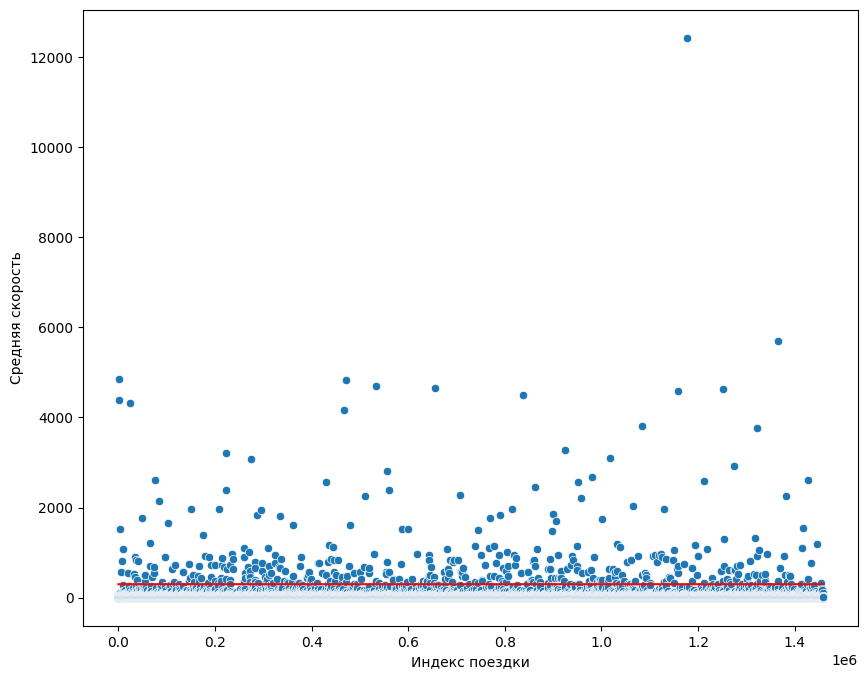

In [38]:
avg_speed = df['total_distance'] / df['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
sns.lineplot(x=avg_speed.index, y=300, linewidth=1.5, color='red', linestyle='-', ax=ax)
ax.set_xlabel('Индекс поездки')
ax.set_ylabel('Средняя скорость');

In [39]:
# выводим результат
print(f'Минимальная средняя скорость движения: {avg_speed.min():.2f} км/ч')
print(f'Максимальная средняя скорость движения: {avg_speed.max():.2f} км/ч')

Минимальная средняя скорость движения: 0.00 км/ч
Максимальная средняя скорость движения: 12428.38 км/ч


Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


---

### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [40]:
# задаём маску по длительности поезки - выше более 86400 сек (1 сутки)
mask_day_duration = df['trip_duration'] > 86400

# ответ на вопрос а)
print(f'Число выбросов по признаку "длительность поездки": {df[mask_day_duration].shape[0]}')

# удаляем выбросы
df = df[~mask_day_duration]

Число выбросов по признаку "длительность поездки": 4


In [41]:
# добавляем новый признак avg_speed в основной датафрейм
df['avg_speed'] = avg_speed

# задаём маску по средней скорости - выше 300
mask_speed = df['avg_speed'] > 300

# ответ на вопрос б)
print(f'Число выбросов по признаку "средняя скорость поездки": {df[mask_speed].shape[0]}')

# удаляем выбросы
df = df[~mask_speed]

# из основного датафрейма убираем ненужные признаки
df.drop(columns=['avg_speed'], inplace=True)

Число выбросов по признаку "средняя скорость поездки": 407


In [42]:
# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458233 non-null  object        
 1   vendor_id           1458233 non-null  int8          
 2   pickup_datetime     1458233 non-null  datetime64[ns]
 3   dropoff_datetime    1458233 non-null  datetime64[ns]
 4   passenger_count     1458233 non-null  int8          
 5   pickup_longitude    1458233 non-null  float32       
 6   pickup_latitude     1458233 non-null  float32       
 7   dropoff_longitude   1458233 non-null  float32       
 8   dropoff_latitude    1458233 non-null  float32       
 9   store_and_fwd_flag  1458233 non-null  int8          
 10  trip_duration       1458233 non-null  int32         
 11  pickup_date         1458233 non-null  datetime64[ns]
 12  pickup_hour         1458233 non-null  int8          
 13  pickup_day_of_wee

In [43]:
# прибираемся немного
del avg_speed, mask_day_duration, mask_speed
del fig, ax
gc.collect();

---

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [44]:
# добавляем логарифмический признак
df['trip_duration_log'] = np.log(df['trip_duration'] + 1)

# понижаем размерность признаков по типу занимаемых данных
df['trip_duration_log'] = df['trip_duration_log'].astype('float32')

# выводим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458233 non-null  object        
 1   vendor_id           1458233 non-null  int8          
 2   pickup_datetime     1458233 non-null  datetime64[ns]
 3   dropoff_datetime    1458233 non-null  datetime64[ns]
 4   passenger_count     1458233 non-null  int8          
 5   pickup_longitude    1458233 non-null  float32       
 6   pickup_latitude     1458233 non-null  float32       
 7   dropoff_longitude   1458233 non-null  float32       
 8   dropoff_latitude    1458233 non-null  float32       
 9   store_and_fwd_flag  1458233 non-null  int8          
 10  trip_duration       1458233 non-null  int32         
 11  pickup_date         1458233 non-null  datetime64[ns]
 12  pickup_hour         1458233 non-null  int8          
 13  pickup_day_of_wee

---

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

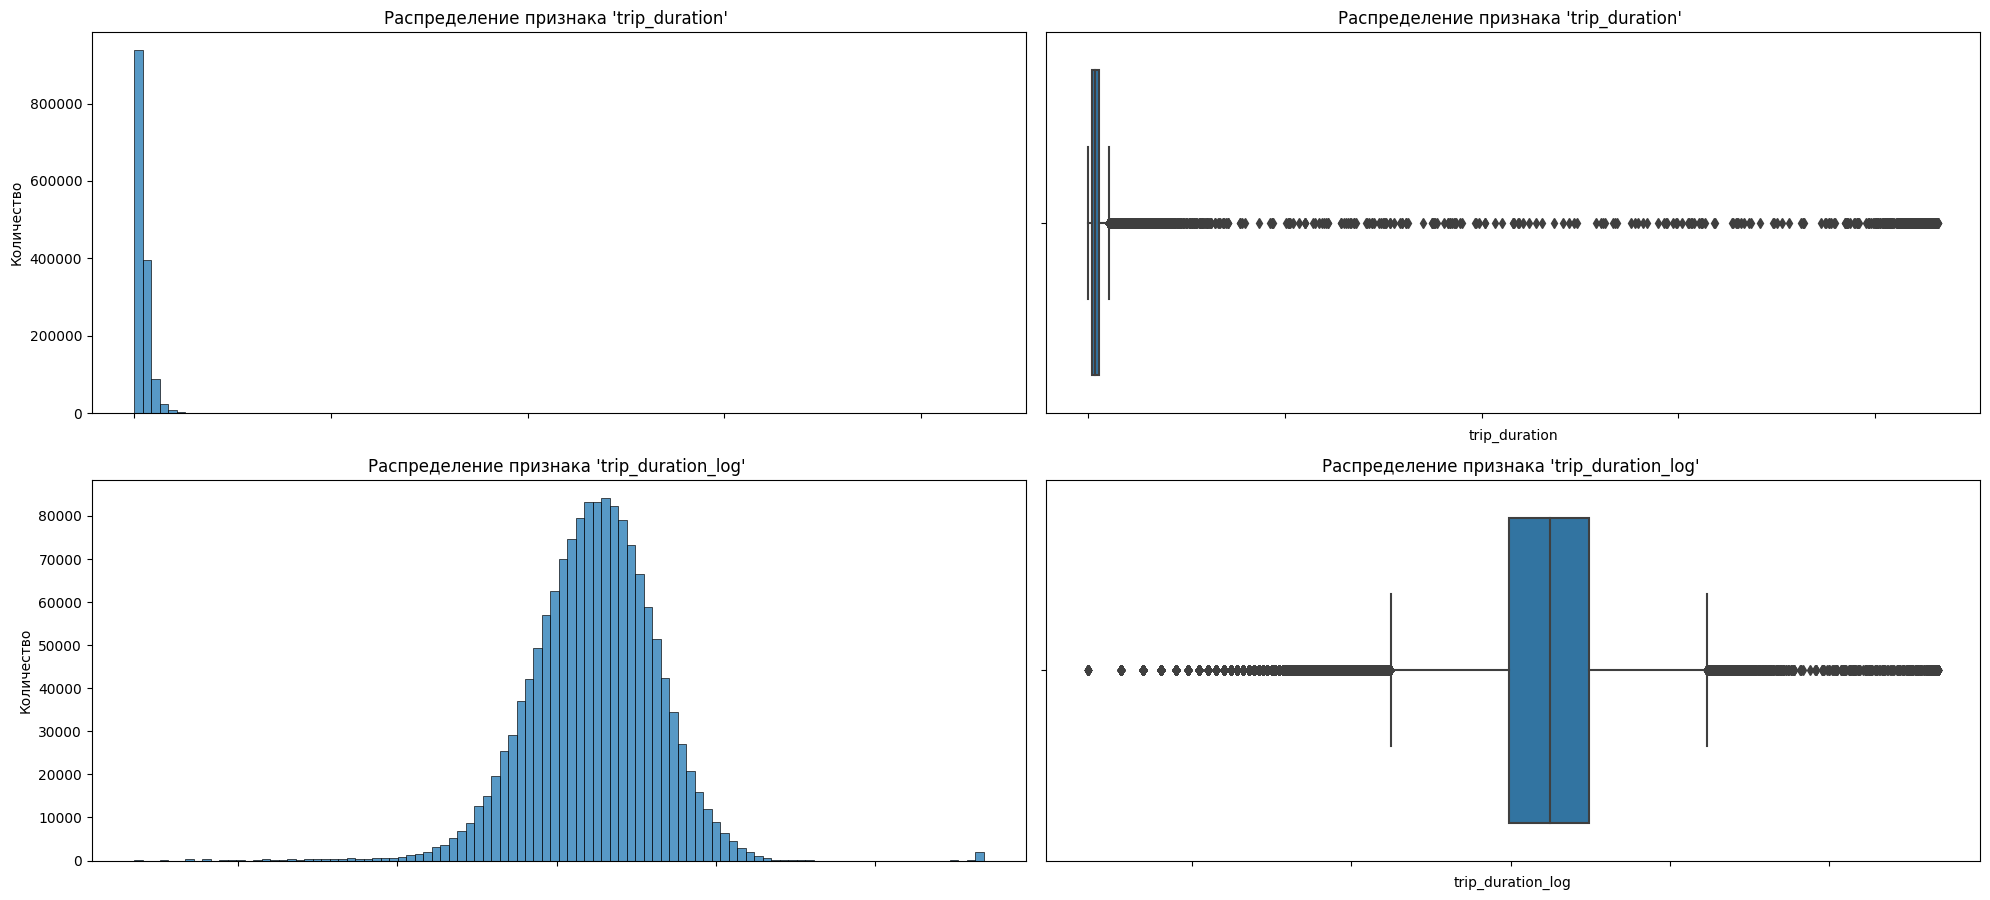

In [45]:
# строим графики
plot_hist_box(df['trip_duration'], df['trip_duration_log'])

In [46]:
# нулевая гипотеза
H_0 = 'Данные имеют гауссово распределение'

# альтернативная гипотеза
H_a = 'Данные не имеют гауссовского распределения'

# уровень значимости
alpha = 0.05

# статистическая значимость для теста Д'Агостино
p_val_K_2 = stats.normaltest(df['trip_duration_log'])[1].__round__(4)

# Тест является двусторонним, то есть рассчитывается статистическая значимость попадания как в левый, 
# так и в правый хвост (эксцесс), поэтому для проверки нулевой гипотезы статистическую значимость (P-value) 
# будем сравнивать с "половинной величиной" уровня значимости.

# интерпретация
if p_val_K_2 > (alpha / 2):
    print(f'Мы не можем отвергнуть нулевую гипотезу. {H_0}, '\
        f'так как P-value ({p_val_K_2}) больше половины уровня значимости ({alpha / 2})')
else:
	print(f'Мы отвергаем нулевую гипотезу. {H_a}, '\
        f'так как P-value ({p_val_K_2}) меньше половины уровня значимости ({alpha / 2})')

Мы отвергаем нулевую гипотезу. Данные не имеют гауссовского распределения, так как P-value (0.0) меньше половины уровня значимости (0.025)


In [47]:
# ответ на вопрос а)
print(f'Вычисленный p-value: {p_val_K_2}')

Вычисленный p-value: 0.0


ответ на вопрос б)

* Да, распределение нормальное
* **Нет, распределение отлично от нормального** (True)

In [48]:
# прибираемся немного
del H_0, H_a, alpha, p_val_K_2
gc.collect();

---

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

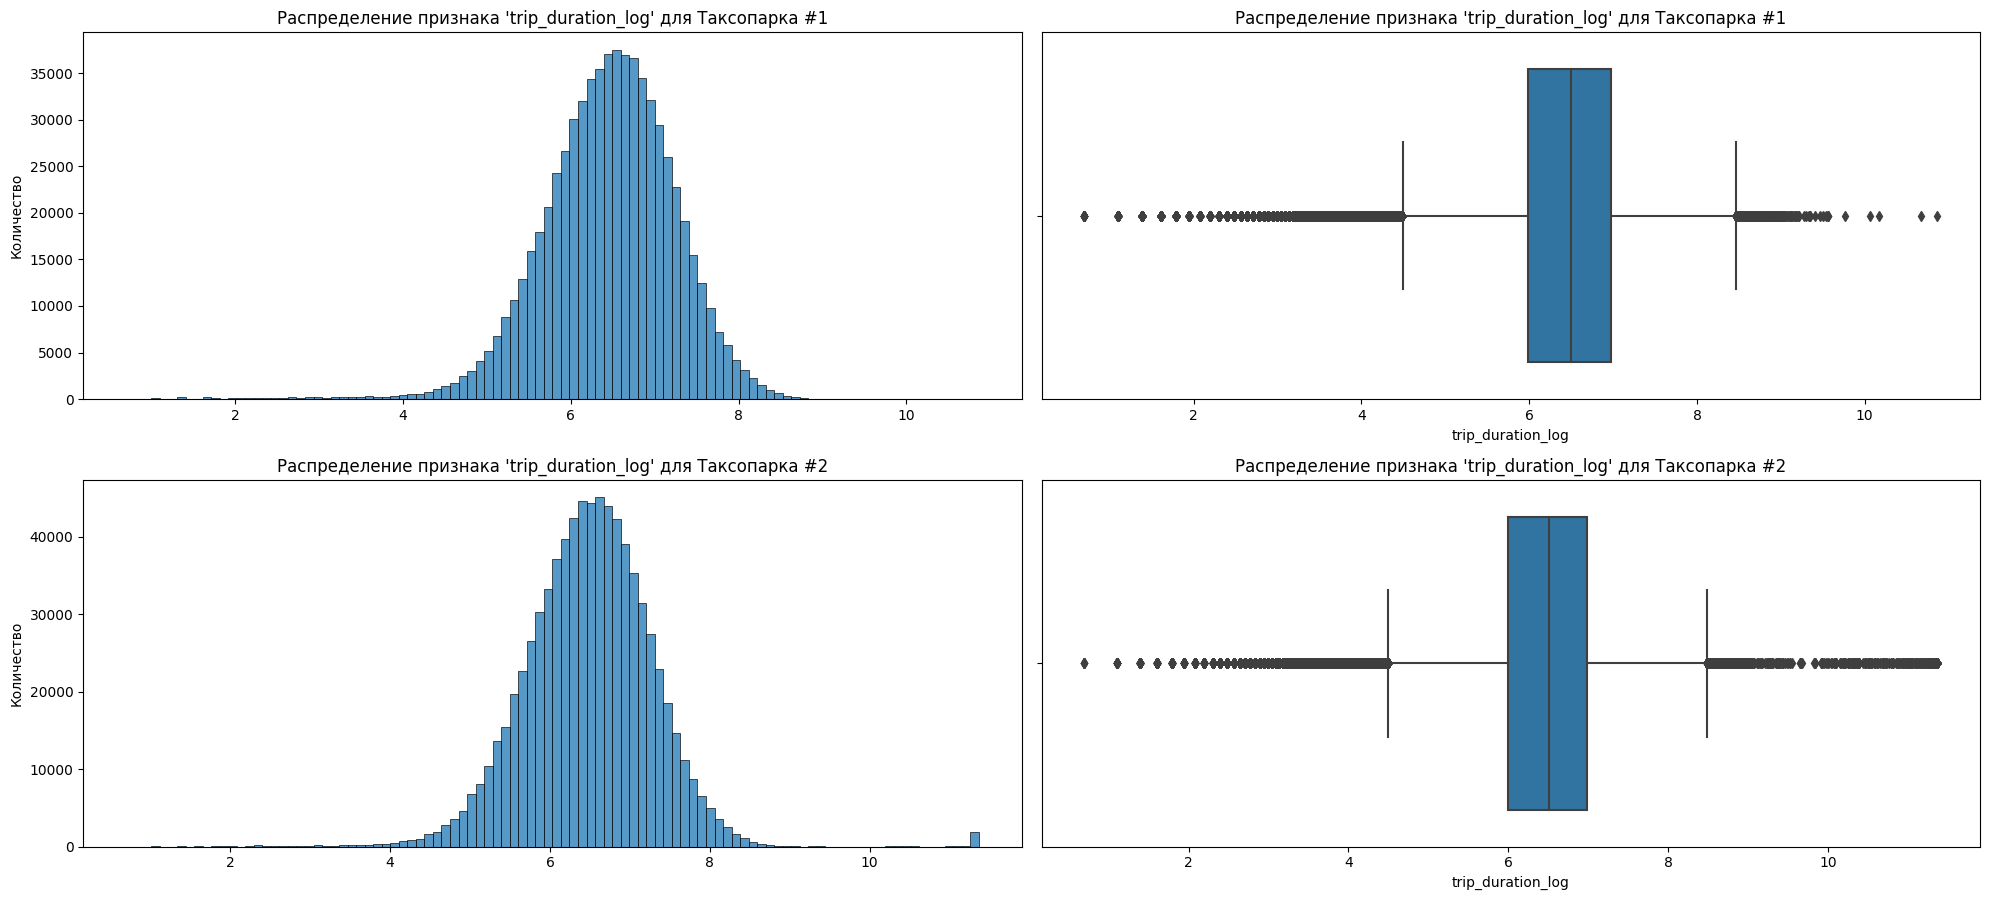

In [49]:
# маска для каждого таксопарка
mask_taxi_park_1 = df['vendor_id'] == 1
mask_taxi_park_2 = df['vendor_id'] == 2

# строим графики
plot_hist_box(
    df[mask_taxi_park_1]['trip_duration_log'], 
    df[mask_taxi_park_2]['trip_duration_log'], 
    legend_str_1='для Таксопарка #1', legend_str_2='для Таксопарка #2', 
    hide_x_ax_vals=False
)

Проанализируйте построенные графики и на их основе определите верное утверждение:

* Распределения в группах значительно отличаются, признак `vendor_id` имеет значение при определении длительности поездки.
* **Распределения в группах практически не отличаются, признак `vendor_id` не имеет значения при определении длительности поездки.** (True)

In [50]:
# прибираемся немного
del mask_taxi_park_1, mask_taxi_park_2
gc.collect();

---

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

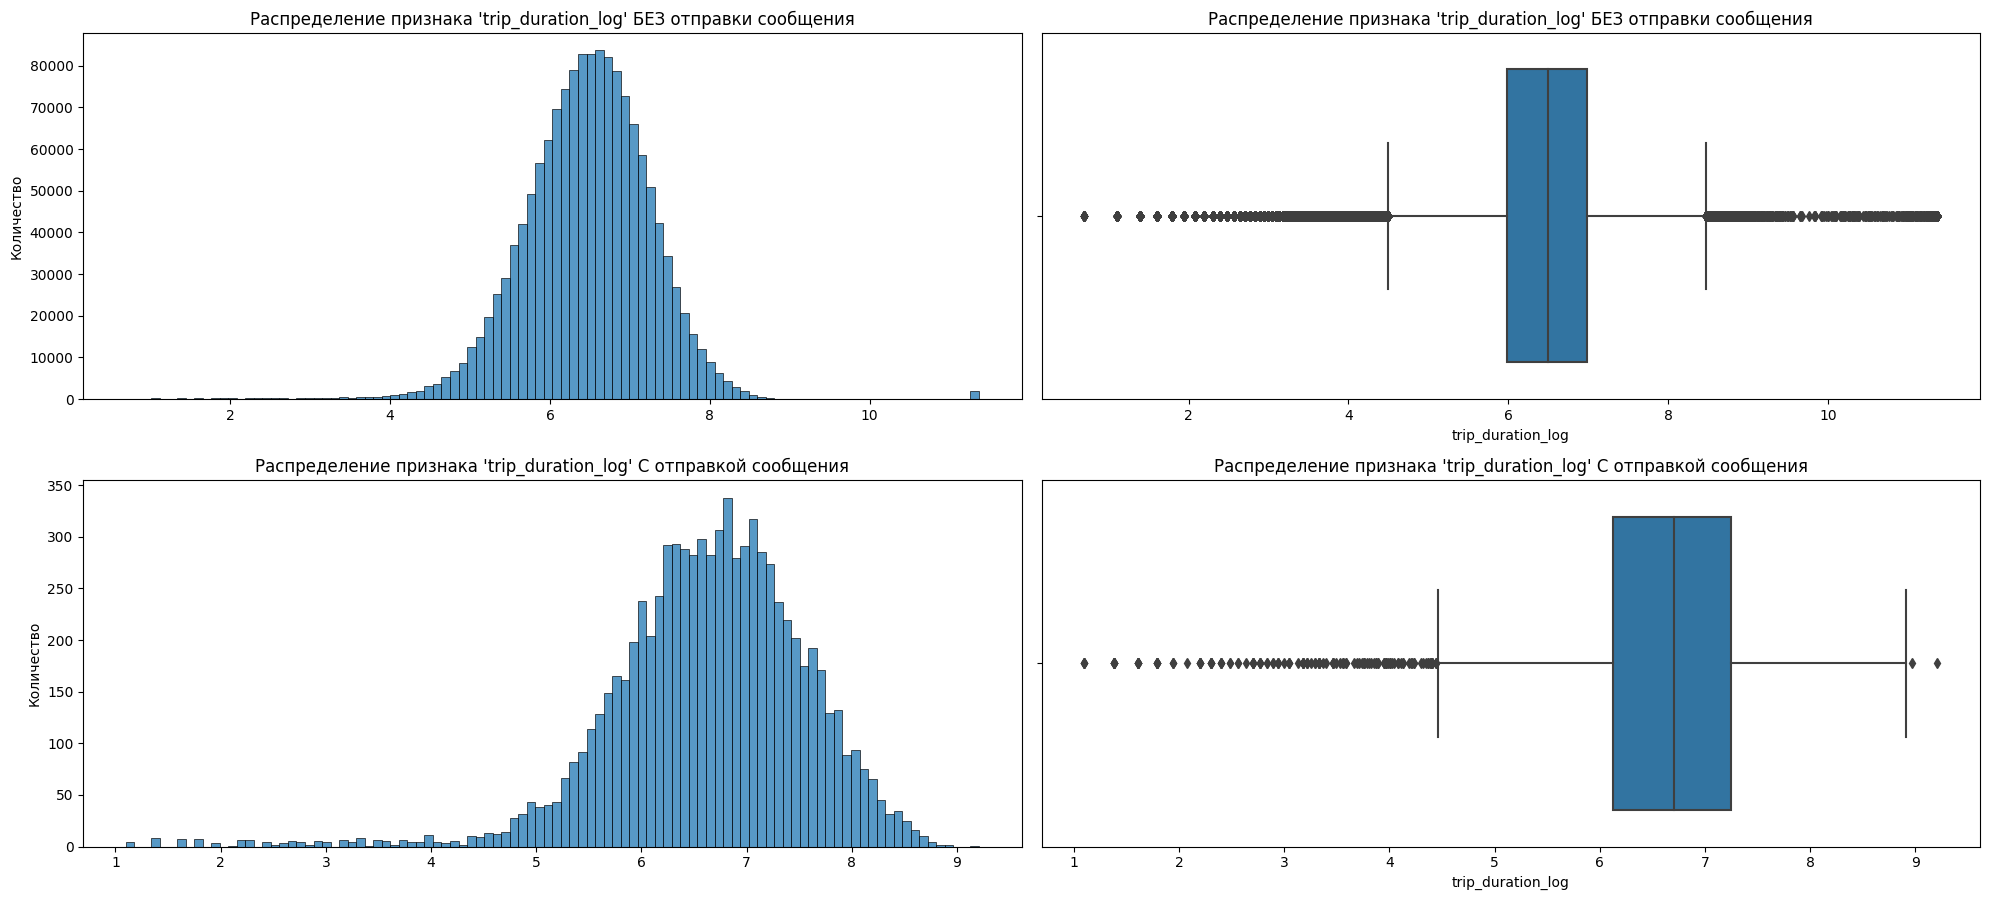

In [51]:
# маска для отправленного сообщения поставщику или нет
mask_fwd_flag_N = df['store_and_fwd_flag'] == 0
mask_fwd_flag_Y = df['store_and_fwd_flag'] == 1

# строим графики
plot_hist_box(
    df[mask_fwd_flag_N]['trip_duration_log'], 
    df[mask_fwd_flag_Y]['trip_duration_log'], 
    legend_str_1='БЕЗ отправки сообщения', legend_str_2='С отправкой сообщения', 
    hide_x_ax_vals=False
)

Проанализируйте построенные графики и на их основе определите верное утверждение:

* **Распределения в группах значительно отличаются, признак `store_and_fwd_flag` имеет значение при определении длительности поездки.** (True)
* Распределения в группах практически не отличаются, признак `store_and_fwd_flag` не имеет значения при определении длительности поездки.

Более длительные поездки принадлежат к группе Y, т.е. флаг "сохранить и переслать поездку" сохраняется только для длительных поездок.

In [52]:
# прибираемся немного
del mask_fwd_flag_N, mask_fwd_flag_Y
gc.collect();

---

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

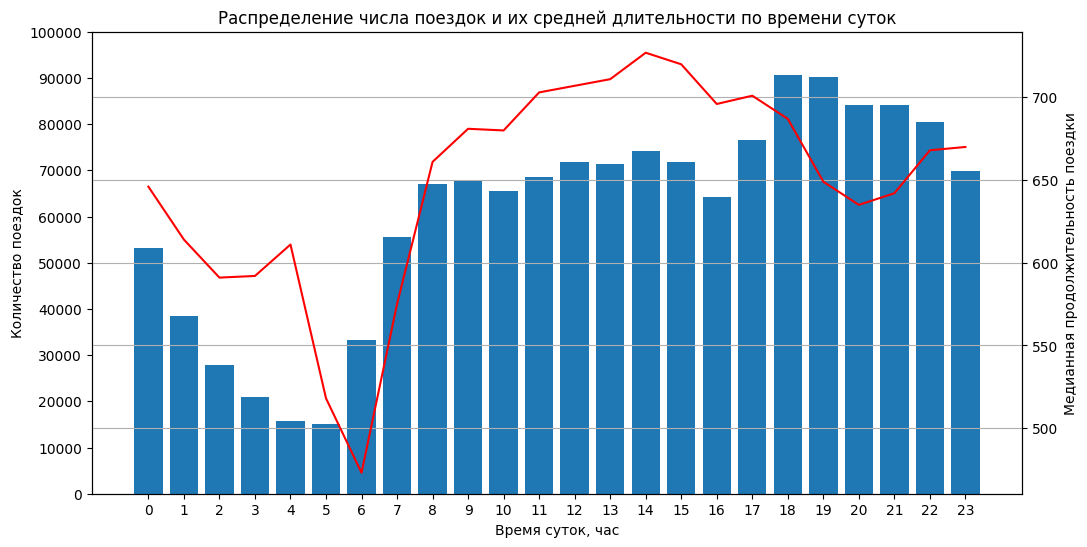

In [53]:
# формируем датафреймы
df_trip_day_count = df.groupby('pickup_hour')['id'].count()
df_trip_day_duration = df.groupby('pickup_hour')['trip_duration'].median()

# строим графики
plot_bar_line(
    df_trip_day_count, df_trip_day_duration, 
    title_='Распределение числа поездок и их средней длительности по времени суток', 
    xlabel_='Время суток, час'
)

ответ на вопрос а)

1. В какое время суток такси заказывают реже всего?

* **с 00:00 по 5:00** (True)
* с 6:00 по 12:00
* с 13:00 по 18:00
* с 18:00 по 23:00

ответ на вопрос б)

2. В какое время суток наблюдается пик медианной длительности поездок?

* с 00:00 по 5:00
* с 6:00 по 12:00
* **с 13:00 по 18:00** (True)
* с 18:00 по 23:00

In [54]:
# прибираемся немного
del df_trip_day_count, df_trip_day_duration
gc.collect();

---

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


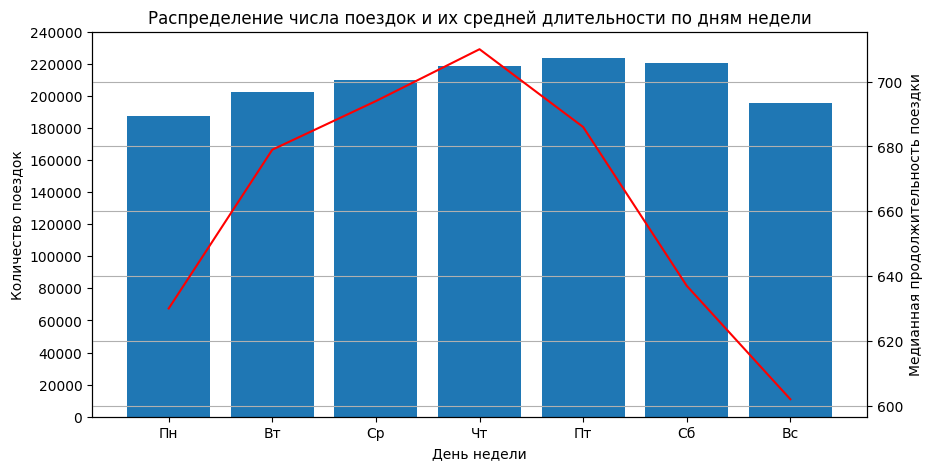

In [55]:
# формируем датафреймы
df_trip_week_count = df.groupby('pickup_day_of_week')['id'].count().reset_index(drop=True)
df_trip_week_duration = df.groupby('pickup_day_of_week')['trip_duration'].median().reset_index(drop=True)

# список дней недели для графика (понадобится далее)
week_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# строим графики
plot_bar_line(
    df_trip_week_count, df_trip_week_duration, 
    title_='Распределение числа поездок и их средней длительности по дням недели', 
    xlabel_='День недели', 
    week_labels_=week_labels, 
    figsize_=(10, 5) 
)

ответ на вопрос а)

1. В какой день недели совершается больше всего поездок?

* Понедельник (Monday)
* Вторник (Tuesday)
* Среда (Wednesday)
* Четверг (Thursday)
* **Пятница (Friday)** (True)
* Суббота (Saturday)
* Воскресенье (Sunday)

2. В какой день недели медианная длительность поездок наименьшая?

* Понедельник (Monday)
* Вторник (Tuesday)
* Среда (Wednesday)
* Четверг (Thursday)
* Пятница (Friday)
* Суббота (Saturday)
* **Воскресенье (Sunday)** (True)

In [56]:
# прибираемся немного
del df_trip_week_count, df_trip_week_duration
gc.collect();

---

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [57]:
# формируем сводную таблицу
pivot_heat = df.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

# смотрим результат
pivot_heat

pickup_day_of_week,1,2,3,4,5,6,7
pickup_hour,,,,,,,
0,598.0,591.0,601.0,609.0,649.0,685.0,675.0
1,567.0,584.0,553.0,564.0,600.0,640.0,643.0
2,565.0,565.0,544.0,576.0,572.0,610.0,604.5
3,600.0,568.0,574.0,584.0,578.0,591.0,608.0
4,640.0,600.5,616.0,595.0,634.0,610.0,598.5
5,519.0,455.0,448.0,480.0,532.0,631.0,634.0
6,462.0,461.0,463.0,471.0,476.0,508.0,554.0
7,575.0,586.0,593.0,599.0,578.0,481.0,474.0
8,672.0,703.0,704.0,721.0,689.0,489.0,460.0


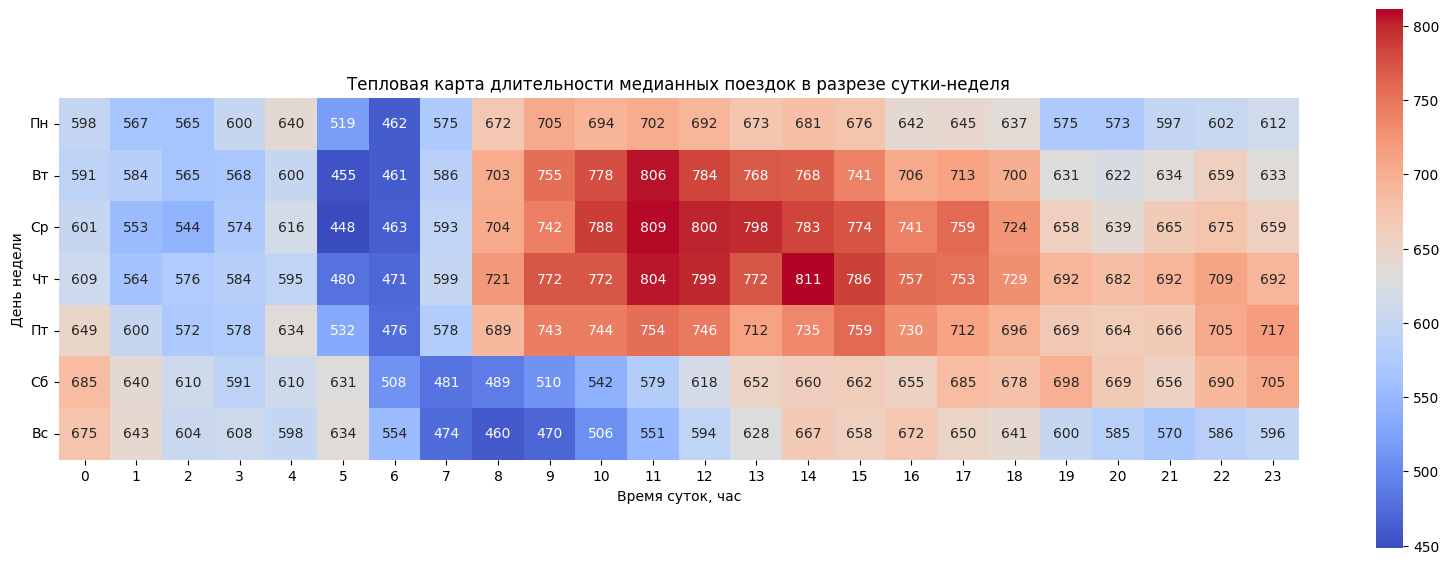

In [58]:
# задаём полотно
fig, ax_heat = plt.subplots(figsize=(20, 7))

# строим график
ax_heat = sns.heatmap(
    pivot_heat.T, 
    annot = True, 
    fmt='.0f', 
    cmap='coolwarm', 
    square=True, 
)

# задаём заголовок, подписи осей
ax_heat.set(
    title='Тепловая карта длительности медианных поездок в разрезе сутки-неделя', 
    xlabel='Время суток, час', 
    ylabel='День недели'
)

# задаём метки по оси ординат и направление меток
ax_heat.set_yticklabels(
    labels=week_labels, 
    rotation=0
);

Выберите все верные варианты ответа:

* **A Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.** (True)
* **B Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.** (True)
* C Наибольшая медианная длительность поездки наблюдалась в понедельник в 17 часов дня.
* D Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 4 до 8 часов.

In [59]:
# прибираемся немного
del week_labels, pivot_heat, fig, ax_heat
gc.collect();

---

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [60]:
# ограчения на границы осей абсцисс и ординат
min_long, max_long = -74.03, -73.75
min_lat, max_lat = 40.63, 40.85
city_long_border = (min_long, max_long)
city_lat_border = (min_lat, max_lat)

# датафрейм координат точек посадки в такси + кластера
df_pickup_coords = df[[
    'pickup_longitude', 'pickup_latitude', 
    'geo_cluster'
    ]
]

# срезовые маски для датафрейма координат точек посадки в такси (для ответа на вопрос)
mask_1 = df_pickup_coords['pickup_longitude'] >= min_long
mask_2 = df_pickup_coords['pickup_longitude'] <= max_long
mask_3 = df_pickup_coords['pickup_latitude'] >= min_lat
mask_4 = df_pickup_coords['pickup_latitude'] <= max_lat

# датафрейм координат точек высадки в такси + кластера
df_dropoff_coords = df[[
    'dropoff_longitude', 'dropoff_latitude',
    'geo_cluster'
    ]
]

# срезовые маски для датафрейма координат точек высадки в такси (для ответа на вопрос)
mask_5 = df_dropoff_coords['dropoff_longitude'] >= min_long
mask_6 = df_dropoff_coords['dropoff_longitude'] <= max_long
mask_7 = df_dropoff_coords['dropoff_latitude'] >= min_lat
mask_8 = df_dropoff_coords['dropoff_latitude'] <= max_lat

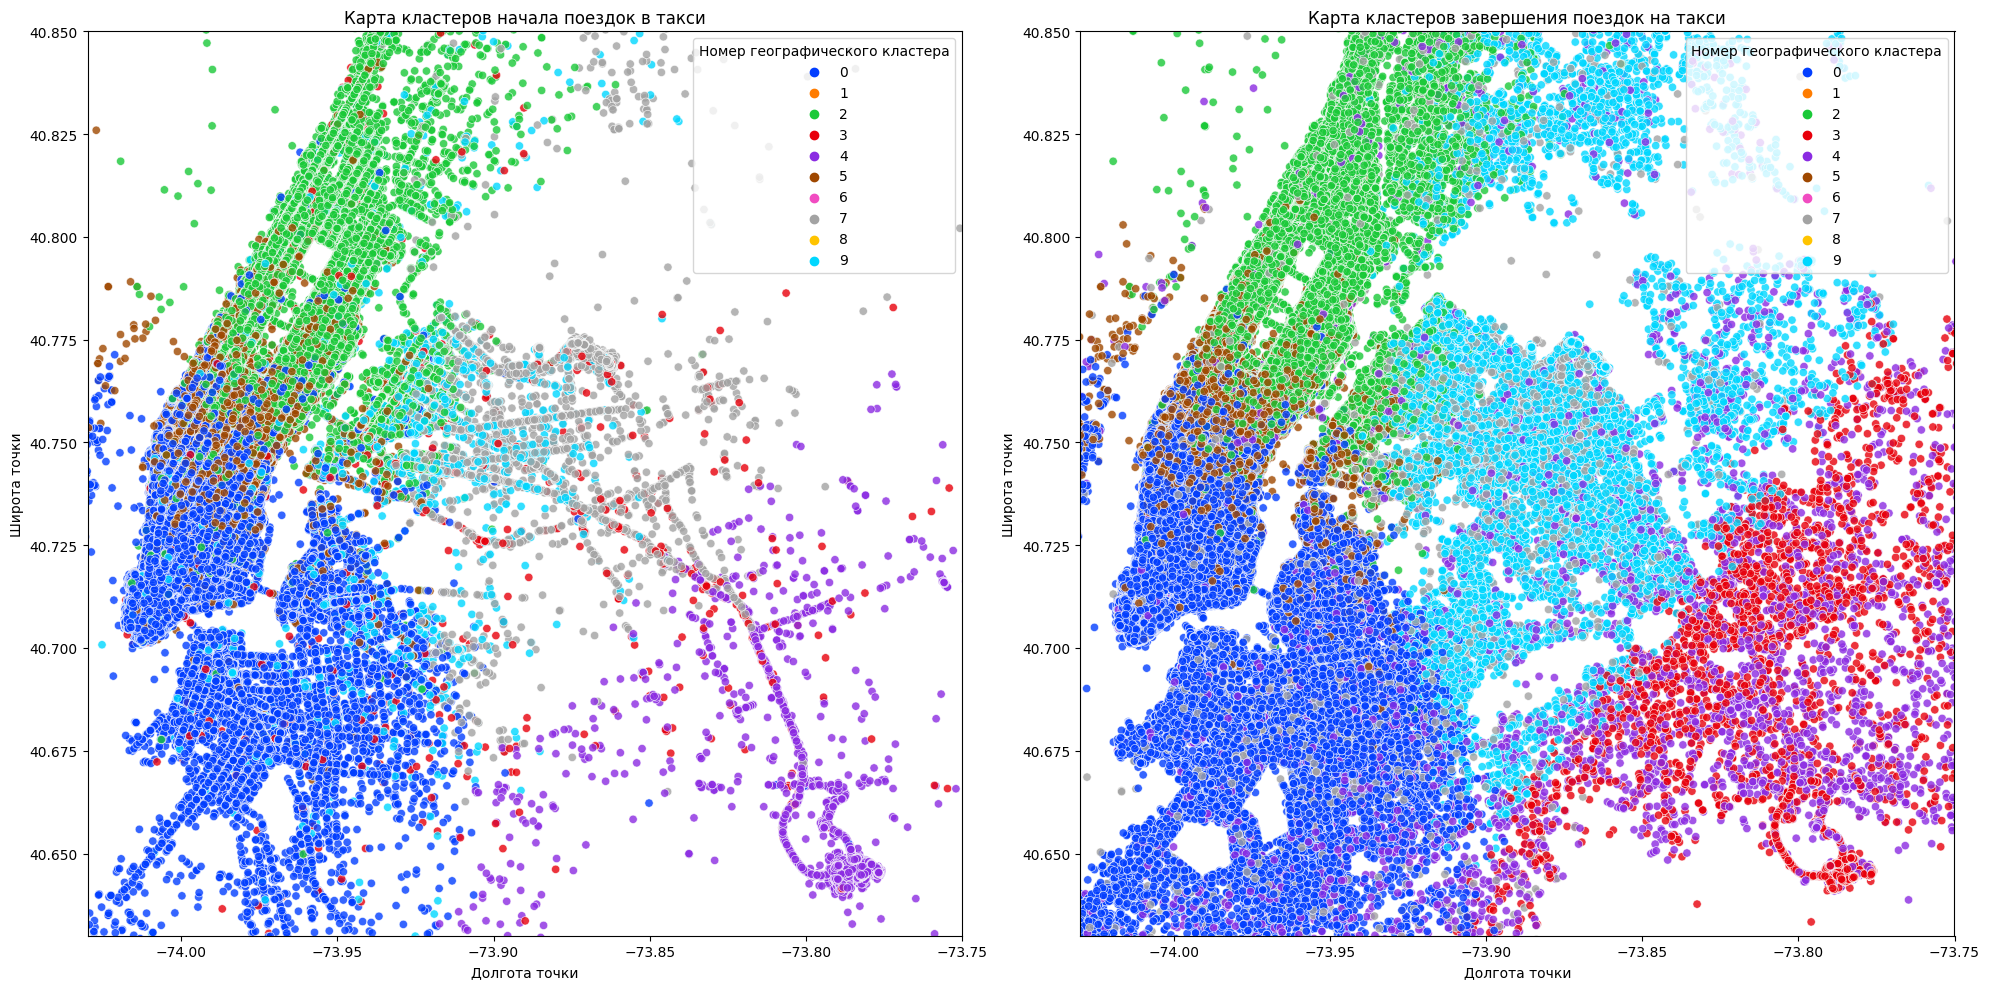

In [61]:
# задаём полотно
fig, ax_scatter = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# строим график на 1-ой субплоскости
plot_scatter_cluster(
    x_col_='pickup_longitude', y_col_='pickup_latitude', 
    ax_=ax_scatter[0], 
    title_='Карта кластеров начала поездок на такси', 
    xlabel_='Долгота точки', 
    ylabel_='Широта точки', 
    df_=df_pickup_coords, 
    x_coords_lim=city_long_border, 
    y_coords_lim=city_lat_border, 
    pnt_size=2
)

# строим график на 2-ой субплоскости
plot_scatter_cluster(
    x_col_='dropoff_longitude', y_col_='dropoff_latitude', 
    ax_=ax_scatter[1], 
    title_='Карта кластеров завершения поездок на такси', 
    xlabel_='Долгота точки', 
    ylabel_='Широта точки', 
    df_=df_dropoff_coords, 
    x_coords_lim=city_long_border, 
    y_coords_lim=city_lat_border, 
    pnt_size=2
)

# выравниваем графики
plt.tight_layout();

Сколько кластеров (из десяти) не попало на диаграммы (находятся за границами Нью-Йорка)?

In [62]:
# ответ на вопрос
print(f'Количество кластеров на карте посадки: '\
    f"{len(df_pickup_coords[mask_1 & mask_2 & mask_3 & mask_4]['geo_cluster'].unique())} "\
    f"из {len(df['geo_cluster'].unique())}")

print(f'Количество кластеров на карте высадки: '\
    f"{len(df_dropoff_coords[mask_5 & mask_6 & mask_7 & mask_8]['geo_cluster'].unique())} "\
    f"из {len(df['geo_cluster'].unique())}")

Количество кластеров на карте посадки: 8 из 10
Количество кластеров на карте высадки: 7 из 10


In [63]:
# прибираемся немного
del min_long, max_long, min_lat, max_lat, city_long_border, city_lat_border
del mask_1, mask_2, mask_3, mask_4, mask_5, mask_6, mask_7, mask_8
del df_pickup_coords, df_dropoff_coords
del fig, ax_scatter
gc.collect();

---

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [64]:
print(f'Размер датафрейма: {df.shape}')
print(f'Признаки: {df.columns}')

Размер датафрейма: (1458233, 27)
Признаки: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'number_of_steps', 'total_distance',
       'total_travel_time', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [65]:
train_data = df.copy()
train_data.head()
train_data.info()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,number_of_steps,total_distance,total_travel_time,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016-03-14,17,1,0,5,2009.099976,164.875,1.498521,99.970192,2,4.398438,8.00000,27.796875,0.300049,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016-06-12,0,7,0,6,2513.199951,332.000,1.805507,-117.153770,0,28.906250,16.09375,7.398438,0.000000,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016-01-19,11,2,0,16,11060.799805,767.500,6.385098,-159.680161,0,-6.699219,16.09375,24.093750,0.000000,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2016-04-06,19,3,0,4,1779.400024,235.750,1.485498,-172.737701,0,7.199219,16.09375,25.906250,0.000000,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,2016-03-26,13,6,0,5,1614.900024,140.125,1.188589,179.473587,2,9.398438,16.09375,9.296875,0.000000,None,6.077642


<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458233 non-null  object        
 1   vendor_id           1458233 non-null  int8          
 2   pickup_datetime     1458233 non-null  datetime64[ns]
 3   dropoff_datetime    1458233 non-null  datetime64[ns]
 4   passenger_count     1458233 non-null  int8          
 5   pickup_longitude    1458233 non-null  float32       
 6   pickup_latitude     1458233 non-null  float32       
 7   dropoff_longitude   1458233 non-null  float32       
 8   dropoff_latitude    1458233 non-null  float32       
 9   store_and_fwd_flag  1458233 non-null  int8          
 10  trip_duration       1458233 non-null  int32         
 11  pickup_date         1458233 non-null  datetime64[ns]
 12  pickup_hour         1458233 non-null  int8          
 13  pickup_day_of_wee

In [66]:
# прибираемся немного
del taxi_data_file, taxi_data_url, taxi_data
gc.collect();

---

### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?

<br>

ответ на вопрос а)

1. Какой из указанных ниже признаков является уникальным для каждой поездки и не несёт полезной информации в определении её продолжительности?

* **id** (True)
* vendor_id
* passenger_count
* store_and_fwd_flag

**Ответ**<br>
Верно: Уникальным для каждой поездки является её идентификатор — столбец *id*. Он никак не связан с длительностью поездки и не имеет значения при её прогнозировании.

ответ на вопрос б)

2. Утечка данных (data leak) — это...

* ситуация, когда модель выучивает тренировочный набор данных.
* инцидент безопасности, при котором конфиденциальная информация становится доступной посторонним лицам.
* **ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.** (True)

ответ на вопрос в)

3. Наличие какого из указанных ниже признаков в обучающем наборе данных создаёт утечку данных?

* pickup_datetime
* **dropoff_datetime** (True)
* passenger_count
* dropoff_longitude
* dropoff_latitude

**Ответ**<br>
Верно: В наших данных утечку создаёт признак *dropoff_datetime* — зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.

In [67]:
train_data.drop(columns=['id', 'dropoff_datetime'], axis=1, inplace=True)

# ответ на вопрос г)
print(f'Размер датафрейма: {train_data.shape}')

Размер датафрейма: (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [68]:
train_data.drop(columns=['pickup_datetime', 'pickup_date'], axis=1, inplace=True)

# выводим результат
print(f'Размер датафрейма: {train_data.shape}')

Размер датафрейма: (1458233, 23)


In [69]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458233 non-null  int8   
 1   passenger_count     1458233 non-null  int8   
 2   pickup_longitude    1458233 non-null  float32
 3   pickup_latitude     1458233 non-null  float32
 4   dropoff_longitude   1458233 non-null  float32
 5   dropoff_latitude    1458233 non-null  float32
 6   store_and_fwd_flag  1458233 non-null  int8   
 7   trip_duration       1458233 non-null  int32  
 8   pickup_hour         1458233 non-null  int8   
 9   pickup_day_of_week  1458233 non-null  int8   
 10  pickup_holiday      1458233 non-null  int8   
 11  number_of_steps     1458233 non-null  int8   
 12  total_distance      1458233 non-null  float32
 13  total_travel_time   1458233 non-null  float16
 14  haversine_distance  1458233 non-null  float32
 15  direction           

---

### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 1 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [70]:
# кодируем признаки
train_data['vendor_id'] = train_data['vendor_id'].swifter.apply(lambda x: 0 if x == 1 else 1)

# выводим результат
train_data.head(3)

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,pickup_holiday,number_of_steps,total_distance,total_travel_time,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,1,0,5,2009.099976,164.875,1.498521,99.970192,2,4.398438,8.00000,27.796875,0.300049,None,6.122493
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,7,0,6,2513.199951,332.000,1.805507,-117.153770,0,28.906250,16.09375,7.398438,0.000000,None,6.498282
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,2,0,16,11060.799805,767.500,6.385098,-159.680161,0,-6.699219,16.09375,24.093750,0.000000,None,7.661527


In [71]:
# ответ на вопрос а)
print(f"Среднее по столбцу 'vendor_id': {train_data['vendor_id'].mean():.2f}")

# ответ на вопрос б)
print(f"Среднее по столбцу 'store_and_fwd_flag': {train_data['store_and_fwd_flag'].mean():.3f}")

Среднее по столбцу 'vendor_id': 0.53
Среднее по столбцу 'store_and_fwd_flag': 0.006


---

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [72]:
# список признаков для кодирования
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# создаём объект класса OneHotEncoder
OHE_encoder = preprocessing.OneHotEncoder(drop='first')
# one_hot_encoder = preprocessing.OneHotEncoder()

# выполняем OneHot-кодирование
data_onehot = OHE_encoder.fit_transform(train_data[columns_to_change]).toarray()
ohe_column_names = OHE_encoder.get_feature_names_out(columns_to_change)

# составляем датафрейм из OneHot-закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=ohe_column_names)

# понижаем размерность признаков по типу занимаемых данных
data_onehot = data_onehot.astype('int8')

# выводим результат
data_onehot.head()
data_onehot.info()

,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,pickup_day_of_week_7,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458233 entries, 0 to 1458232
Data columns (total 18 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   pickup_day_of_week_2  1458233 non-null  int8 
 1   pickup_day_of_week_3  1458233 non-null  int8 
 2   pickup_day_of_week_4  1458233 non-null  int8 
 3   pickup_day_of_week_5  1458233 non-null  int8 
 4   pickup_day_of_week_6  1458233 non-null  int8 
 5   pickup_day_of_week_7  1458233 non-null  int8 
 6   geo_cluster_1         1458233 non-null  int8 
 7   geo_cluster_2         1458233 non-null  int8 
 8   geo_cluster_3         1458233 non-null  int8 
 9   geo_cluster_4         1458233 non-null  int8 
 10  geo_cluster_5         1458233 non-null  int8 
 11  geo_cluster_6         1458233 non-null  int8 
 12  geo_cluster_7         1458233 non-null  int8 
 13  geo_cluster_8         1458233 non-null  int8 
 14  geo_cluster_9         1458233 non-null  int8 
 15  events_None    

In [73]:
# ответ на вопрос (18)
data_onehot.shape

(1458233, 18)

Добавим полученную таблицу с закодированными признаками:

In [74]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print(f'Размер датафрейма: {train_data.shape}')

Размер датафрейма: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [75]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
# y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [76]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=RANDOM_SEED_42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


In [77]:
# прибираемся немного
del ohe_column_names, data_onehot
del X, y_log
del df, train_data
gc.collect();

---

### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [78]:
# выбираем лучшие признаки по методу "выбор k лучших переменных" (SelectKBest)
SKBst_selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25);
SKBst_selector.fit(X_train, y_train_log);

# выводим отобранные признаки
SKBst_selector_cols = list(SKBst_selector.get_feature_names_out())
SKBst_selector_cols

SelectKBest(k=25, score_func=<function f_regression at 0x0000018DC93E9240>)

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_hour',
 'pickup_holiday',
 'number_of_steps',
 'total_distance',
 'total_travel_time',
 'haversine_distance',
 'temperature',
 'pickup_day_of_week_3',
 'pickup_day_of_week_4',
 'pickup_day_of_week_5',
 'pickup_day_of_week_6',
 'pickup_day_of_week_7',
 'geo_cluster_2',
 'geo_cluster_3',
 'geo_cluster_4',
 'geo_cluster_5',
 'geo_cluster_7',
 'geo_cluster_9']

ответ на вопрос:

Укажите признаки, которые вошли в список отобранных:

* **A vendor_id** (True)
* **B passenger_count** (True)
* **C number_of_steps** (True)
* **D temperature** (True)
* E events_None
* F visibility
* G wind speed

In [79]:
# выбираем k-признаки из данных
X_train = X_train[SKBst_selector_cols]
X_valid = X_valid[SKBst_selector_cols]

# выводим результат
X_train.info()
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977016 entries, 293850 to 121958
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vendor_id             977016 non-null  int64  
 1   passenger_count       977016 non-null  int8   
 2   pickup_longitude      977016 non-null  float32
 3   pickup_latitude       977016 non-null  float32
 4   dropoff_longitude     977016 non-null  float32
 5   dropoff_latitude      977016 non-null  float32
 6   store_and_fwd_flag    977016 non-null  int8   
 7   pickup_hour           977016 non-null  int8   
 8   pickup_holiday        977016 non-null  int8   
 9   number_of_steps       977016 non-null  int8   
 10  total_distance        977016 non-null  float32
 11  total_travel_time     977016 non-null  float16
 12  haversine_distance    977016 non-null  float32
 13  temperature           977016 non-null  float16
 14  pickup_day_of_week_3  977016 non-null  int8   
 15  

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


In [80]:
# прибираемся немного
del SKBst_selector
gc.collect();

---

### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [81]:
# задаём объект класса скейлер MinMaxScaler
MMS_scaler = preprocessing.MinMaxScaler();

# обучаем скейлер, подгоняем данные
MMS_scaler.fit(X_train);

# транформируем данные обученным скейлером
X_train_scaled = MMS_scaler.transform(X_train)
X_valid_scaled = MMS_scaler.transform(X_valid)

MinMaxScaler()

In [82]:
# ответ на вопрос
print(f'Среднее арифметическое первого предиктора: {X_valid_scaled[:, 0].mean():.2f}')

Среднее арифметическое первого предиктора: 0.54


In [83]:
# прибираемся немного
del X_train, X_valid
gc.collect();

---

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [84]:
get_model_metrics(
    get_estimator('linear'), 
    X_train_=X_train_scaled, y_train_=y_train_log, 
    X_test_=X_valid_scaled, y_test_=y_valid_log
)

# ответ в модуле: 0.54 и 0.54 !!!

-= LinearRegression =-
RMSLE на обучающей выборке: 0.53207
RMSLE на валидационной выборке: 0.53456


---

### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [85]:
# создаём скейлер-генератор полиномиальных признаков
# degree. Default to 2.
PF_scaler = preprocessing.PolynomialFeatures(include_bias=False);
PF_scaler.fit(X_train_scaled);

# генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = PF_scaler.transform(X_train_scaled);

# генерируем полиномиальные признаки для тестовой выборки
X_valid_scaled_poly = PF_scaler.transform(X_valid_scaled);

# выводим результат
X_train_scaled_poly.shape
X_valid_scaled_poly.shape

PolynomialFeatures(include_bias=False)

(977016, 350)

(481217, 350)

In [86]:
# ответ на вопрос а)
get_model_metrics(
    get_estimator('linear'), 
    X_train_=X_train_scaled_poly, y_train_=y_train_log, 
    X_test_=X_valid_scaled_poly, y_test_=y_valid_log
)

# ответ в модуле: 0.47 и 0.7 !!!

-= LinearRegression =-
RMSLE на обучающей выборке: 0.46466
RMSLE на валидационной выборке: 0.66717


ответ на вопрос б)

2. Наблюдаются ли у вашей модели признаки переобучения?
* **Да** (True)
* Нет

---

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [87]:
# ответ на вопрос
get_model_metrics(
    get_estimator('ridge'), 
    X_train_=X_train_scaled_poly, y_train_=y_train_log, 
    X_test_=X_valid_scaled_poly, y_test_=y_valid_log
)

# ответ в модуле: 0.48 и 0.48 !!!

-= Ridge =-
RMSLE на обучающей выборке: 0.47395
RMSLE на валидационной выборке: 0.47681


In [88]:
# прибираемся немного
del PF_scaler, X_train_scaled_poly, X_valid_scaled_poly
gc.collect();

---

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [89]:
# ответ на вопрос а)
get_model_metrics(
    get_estimator('dtr'), 
    X_train_=X_train_scaled, y_train_=y_train_log, 
    X_test_=X_valid_scaled, y_test_=y_valid_log
)

-= DecisionTreeRegressor =-
RMSLE на обучающей выборке: 0.00305
RMSLE на валидационной выборке: 0.56588


ответ на вопрос б)

2. Наблюдаются ли у вашей модели признаки переобучения?
* **Да** (True)
* Нет

---

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [103]:
# задаём границы глубины деревьев
start, stop = 7, 20
metrics_ord_dict = OrderedDict()

# цикл для всех шагов глубины дерева
for step in range(start, stop + 1):
    # словарь параметров модели
    params_dtr = {
        'max_depth': step
    }

    # результаты метрик заносим в OrderedDict
    # ключ равен текущей глубине дерева (шагу итерации)
    DTR, _, metrics_ord_dict[step] = get_model_metrics(
        get_estimator('dtr', **params_dtr), 
        X_train_=X_train_scaled, y_train_=y_train_log, 
        X_test_=X_valid_scaled, y_test_=y_valid_log, 
        print_metrics=False, 
        return_values=True
    )

    # выводим результат
    print(f'Max_depth: {step:2d}, '\
        f'RMSLE train: {metrics_ord_dict[step][0]:.{TOL}f}, '\
        f'RMSLE valid: {metrics_ord_dict[step][1]:.{TOL}f}')

Max_depth:  7, RMSLE train: 0.44482, RMSLE valid: 0.44716
Max_depth:  8, RMSLE train: 0.43700, RMSLE valid: 0.44077
Max_depth:  9, RMSLE train: 0.42995, RMSLE valid: 0.43556
Max_depth: 10, RMSLE train: 0.42255, RMSLE valid: 0.43102
Max_depth: 11, RMSLE train: 0.41463, RMSLE valid: 0.42970
Max_depth: 12, RMSLE train: 0.40588, RMSLE valid: 0.42976
Max_depth: 13, RMSLE train: 0.39563, RMSLE valid: 0.43245
Max_depth: 14, RMSLE train: 0.38360, RMSLE valid: 0.43862
Max_depth: 15, RMSLE train: 0.37020, RMSLE valid: 0.44513
Max_depth: 16, RMSLE train: 0.35543, RMSLE valid: 0.45231
Max_depth: 17, RMSLE train: 0.33928, RMSLE valid: 0.46372
Max_depth: 18, RMSLE train: 0.32190, RMSLE valid: 0.47327
Max_depth: 19, RMSLE train: 0.30322, RMSLE valid: 0.48468
Max_depth: 20, RMSLE train: 0.28403, RMSLE valid: 0.49423


In [104]:
# ответ на вопрос а) и б)
# ищем в OrderedDict кортеж (пару) с наименьшим значением в паре среди всех кортежей
min_pair = min(metrics_ord_dict.values(), key=lambda x: x[1])

# ищем ключ кортежа в OrderedDict от пары с наименьшим значением
key = list(metrics_ord_dict.keys())[list(metrics_ord_dict.values()).index(min_pair)]

# индекс ключа от кортежа (пары) с наименьшим значением
best_max_depth = list(metrics_ord_dict.keys()).index(key)

# задаём списки для переноса значений
train_scores, valid_scores = [], []

# забираем по ключу соответствующие значения из кортежей в 1 и 2 списки
for step in metrics_ord_dict.values():
    train_scores.append(step[0])
    valid_scores.append(step[1])

# выводим результат
print(f'Лучшая глубина дерева: {key}')
print(f'RMSLE train с max_depth {key}: {train_scores[best_max_depth]:.{TOL}f}')
print(f'RMSLE valid с max_depth {key}: {valid_scores[best_max_depth]:.{TOL}f}')

# ответ в модуле: 12 !!!

Лучшая глубина дерева: 11
RMSLE train с max_depth 11: 0.41463
RMSLE valid с max_depth 11: 0.42970


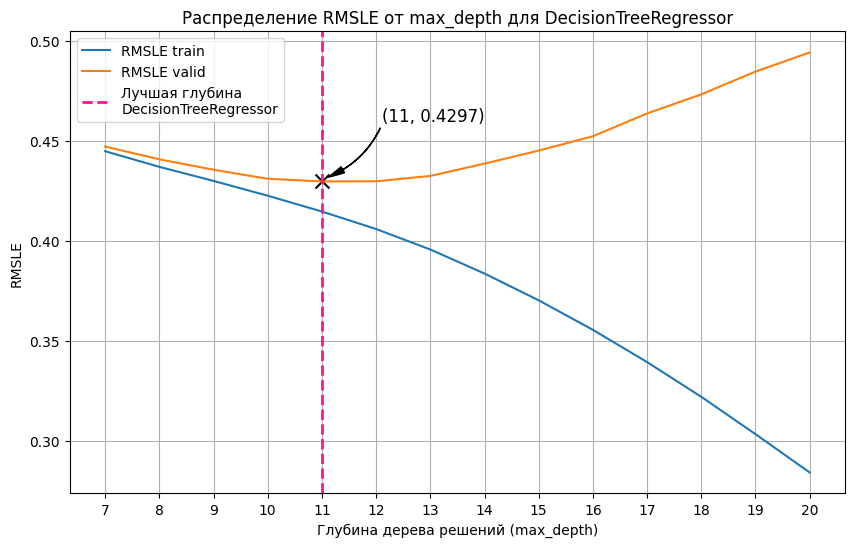

In [105]:
# задаём полотно
fig, ax = plt.subplots(figsize=(10, 6))

# выделяем координаты
x_, y_ = key, round(valid_scores[best_max_depth], TOL)

# строим графики
sns.lineplot(x=range(start, stop + 1), y=train_scores, label='RMSLE train', ax=ax)
sns.lineplot(x=range(start, stop + 1), y=valid_scores, label='RMSLE valid', ax=ax)
plt.axvline(x=x_, label=f'Лучшая глубина\n{DTR.__class__.__name__}', lw=2, c='deeppink', ls='--')

# аннотируем детали графика
plt.scatter(x=x_, y=y_, c='black', marker='x', s=100)
plt.annotate(
    f'({x_}, {y_})',
    xy=(x_*1.01, y_*1.005),
    xytext=(x_*1.1, y_*1.07),
    arrowprops = dict(
        facecolor='black', 
        width=0.2, 
        headwidth=5,
        connectionstyle="arc3, rad=-0.2"
    ),
    fontsize=12,
    horizontalalignment='left')

# задаём заголовок, подписи и лимиты оси абсцисс
ax.set(
    title=f'Распределение RMSLE от max_depth для {DTR.__class__.__name__}', 
    xlabel='Глубина дерева решений (max_depth)', 
    ylabel='RMSLE', 
    xticks=range(start, stop + 1)
)

# выводим сетку и легенду
ax.grid()
ax.legend();

In [106]:
# прибираемся немного
del start, stop, step, DTR, metrics_ord_dict, params_dtr
del min_pair, best_max_depth, train_scores, valid_scores
del x_, y_, fig, ax
gc.collect();

---

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [107]:
params_rfr = {
    'n_estimators':200, 
    'max_depth':key, 
    'criterion':'squared_error', 
    'min_samples_split':20, 
    'verbose':True
}

get_model_metrics(
    get_estimator('rfr', **params_rfr), 
    X_train_=X_train_scaled, y_train_=y_train_log, 
    X_test_=X_valid_scaled, y_test_=y_valid_log
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


-= RandomForestRegressor =-
RMSLE на обучающей выборке: 0.40791
RMSLE на валидационной выборке: 0.41822


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    1.2s finished


In [108]:
# прибираемся немного
del params_rfr, key
gc.collect();

---

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [109]:
params_gbr = {
    'learning_rate':0.5, 
    'n_estimators':100, 
    'max_depth':6, 
    'min_samples_split':30, 
    'verbose':True
}

# возвращаем модель и предсказанные значения на валидационной выборке
GBR, y_pred_valid_gbr_log, *_ = get_model_metrics(
    get_estimator('gbr', **params_gbr), 
    X_train_=X_train_scaled, y_train_=y_train_log, 
    X_test_=X_valid_scaled, y_test_=y_valid_log, 
    return_values=True
)

      Iter       Train Loss   Remaining Time 
         1           0.3110            9.67m
         2           0.2247            9.52m
         3           0.1987            9.44m
         4           0.1876            9.33m
         5           0.1825            9.25m
         6           0.1791            9.12m
         7           0.1759            9.08m
         8           0.1741            8.96m
         9           0.1723            8.85m
        10           0.1710            8.77m
        20           0.1586            7.77m
        30           0.1539            6.73m
        40           0.1497            5.77m
        50           0.1475            4.76m
        60           0.1451            3.80m
        70           0.1434            2.84m
        80           0.1413            1.89m
        90           0.1398           56.64s
       100           0.1382            0.00s
-= GradientBoostingRegressor =-
RMSLE на обучающей выборке: 0.37172
RMSLE на валидационной выборке:

In [132]:
# прибираемся немного
del params_gbr
gc.collect();

---

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* <font color=Tomato>**&cross;**</font> Линейная регрессия
* <font color=Tomato>**&cross;**</font> Полиномиальная регрессия 2-ой степени
* <font color=Tomato>**&cross;**</font> Дерево решений
* <font color=Tomato>**&cross;**</font> Случайный лес
* <font color=LightSeaGreen>**&check;**</font> **Градиентный бустинг над деревьями решений**
* <font color=LightSeaGreen>**&check;**</font> **XGBoost**

| Обученная модель | RMSLE<br> на валидационной выборке |
| :---: | :---: |
| Линейная регрессия | 0.53 |
| Полиномиальная регрессия 2-ой степени | 0.48 |
| Дерево решений | 0.43 |
| Случайный лес | 0.41 |
| **Градиентный бустинг над деревьями решений** | <font color=LightSeaGreen>**0.394**</font> |
| **XGBoost** | <font color=LightSeaGreen>**0.392**</font> |

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


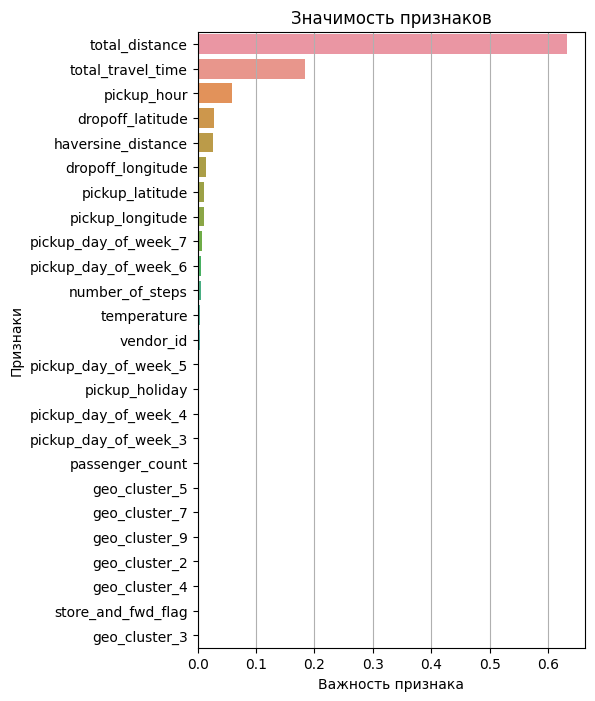

In [111]:
# задаём полотно
fig, ax = plt.subplots(figsize=(5, 8))

# формируем датасет для построения столбчатого графика
feat_importances = pd.Series(
    GBR.feature_importances_, 
    index=SKBst_selector_cols).sort_values(
        ascending=False
)

# задаём сетку
ax.grid()

# строим график
sns.barplot(
    x=feat_importances, 
    y=feat_importances.index, 
    orient='h'
)

# задаём заголовок, подписи осей
ax.set(
    title='Значимость признаков', 
    xlabel='Важность признака', 
    ylabel='Признаки'
);

In [112]:
print(f'Топ-3 наиболее значимых признака для предсказания:\n{feat_importances[:3]}')


Топ-3 наиболее значимых признака для предсказания:
total_distance       0.632008
total_travel_time    0.183998
pickup_hour          0.058438
dtype: float64


In [113]:
# прибираемся немного
del fig, ax, feat_importances
gc.collect();

---

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [114]:
# переводим вектора целевого и предсказанных значений из логарифмического в обычный вид
y_valid = np.exp(y_valid_log) - 1
y_pred_valid_gbr = np.exp(y_pred_valid_gbr_log) - 1

# вычисляем метрику MeAE
round(metrics.median_absolute_error(y_valid, y_pred_valid_gbr) / 60, 1)

1.8

In [115]:
# прибираемся немного
del y_valid, y_pred_valid_gbr, y_pred_valid_gbr_log
gc.collect();

---

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [116]:
# задаём переменные для выгрузки датасета
test_data_file = DATA_SUBFOLDER + './data/Project5_test_data.csv'
test_data_url = 'https://drive.google.com/file/d/1C2N2mfONpCVrH95xHJjMcueXvvh_-XYN/view'

# загружаем датасет
test_data = get_dataset(test_data_file, test_data_url, 'g', ',', DATA_SUBFOLDER + './data/test.csv')

# задаём переменные для выгрузки датасета
osrm_data_test_file = DATA_SUBFOLDER + './data/Project5_osrm_data_test.csv'
osrm_data_test_url = 'https://drive.google.com/file/d/1wCoS-yOaKFhd1h7gZ84KL9UwpSvtDoIA/view'

# загружаем датасет
osrm_data_test = get_dataset(osrm_data_test_file, osrm_data_test_url, 'g', ',', DATA_SUBFOLDER + './data/osrm_data_test.csv')

test_id = test_data['id']

In [117]:
# прибираемся немного
del test_data_file, test_data_url
del osrm_data_test_file, osrm_data_test_url
gc.collect();

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [118]:
# применяем преобразования с помощью функции
test_data = modify_data_types(test_data)
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, KMns)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

# понижаем размерность признаков по типу занимаемых данных
test_data['number_of_steps'] = test_data['number_of_steps'].astype('int8')

# кодируем признаки
test_data['vendor_id'] = test_data['vendor_id'].swifter.apply(lambda x: 0 if x == 1 else 1)

# выполняем OneHot-кодирование
test_data_onehot = OHE_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = OHE_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

# понижаем размерность признаков по типу занимаемых данных
test_data_onehot = test_data_onehot.astype('int8')

# составляем датафрейм из OneHot-закодированных признаков
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)

# выбираем k-признаки из данных
X_test = test_data[SKBst_selector_cols]

# транформируем данные обученным скейлером
X_test_scaled = MMS_scaler.transform(X_test)

# выводим результат
print(f'Shape of data: {X_test.shape}')

Pandas Apply:   0%|          | 0/625134 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/24 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/625134 [00:00<?, ?it/s]

Shape of data: (625134, 25)


In [119]:
# выводим результат
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    625134 non-null  object        
 1   vendor_id             625134 non-null  int64         
 2   pickup_datetime       625134 non-null  datetime64[ns]
 3   passenger_count       625134 non-null  int8          
 4   pickup_longitude      625134 non-null  float32       
 5   pickup_latitude       625134 non-null  float32       
 6   dropoff_longitude     625134 non-null  float32       
 7   dropoff_latitude      625134 non-null  float32       
 8   store_and_fwd_flag    625134 non-null  int8          
 9   pickup_date           625134 non-null  datetime64[ns]
 10  pickup_hour           625134 non-null  int8          
 11  pickup_holiday        625134 non-null  int8          
 12  number_of_steps       625134 non-null  int8          
 13 

In [120]:
# прибираемся немного
del osrm_data_test, X_test, test_data_onehot, test_data
del KMns, OHE_encoder, MMS_scaler
del weather_data, holiday_data
del column_names, columns_to_change
gc.collect();

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [121]:
y_test_pred_gbr_log = GBR.predict(X_test_scaled)
y_test_pred = np.exp(y_test_pred_gbr_log) - 1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv(DATA_SUBFOLDER + './data/submission_gbr.csv', index=False)

In [122]:
# прибираемся немного
del y_test_pred_gbr_log, y_test_pred, test_id, submission
# del GBR
gc.collect();

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [123]:
#!pip install xgboost

После чего модуль можно импортировать:

In [124]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [125]:
# создаём матрицы наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=SKBst_selector_cols)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=SKBst_selector_cols)
dtest = xgb.DMatrix(X_test_scaled, feature_names=SKBst_selector_cols)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [126]:
# гиперпараметры модели
params_xgb = {
    'min_child_weight': 20, 
    'eta': 0.1, 
    'colsample_bytree': 0.9, 
    'max_depth': 6, 
    'subsample': 0.9, 
    'lambda': 1, 
    'nthread': -1, 
    'booster': 'gbtree', 
    'eval_metric': 'rmse', 
    'objective': 'reg:squarederror'
}

# тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# обучаем модель XGBoost
XGB = xgb.train(
    params=params_xgb,          # гиперпараметры модели
    dtrain=dtrain,              # обучающая выборка
    num_boost_round=300,        # количество моделей в ансамбле
    evals=watchlist,            # выборки, на которых считается матрица
    early_stopping_rounds=20,   # раняя остановка
    maximize=False,             # смена поиска максимума на минимум
    verbose_eval=25             # шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42189
[25]	train-rmse:0.57527	valid-rmse:0.57675
[50]	train-rmse:0.40985	valid-rmse:0.41305
[75]	train-rmse:0.40074	valid-rmse:0.40474
[100]	train-rmse:0.39670	valid-rmse:0.40143
[125]	train-rmse:0.39276	valid-rmse:0.39822
[150]	train-rmse:0.38999	valid-rmse:0.39636
[175]	train-rmse:0.38821	valid-rmse:0.39529
[200]	train-rmse:0.38636	valid-rmse:0.39437
[225]	train-rmse:0.38501	valid-rmse:0.39382
[250]	train-rmse:0.38324	valid-rmse:0.39265
[275]	train-rmse:0.38206	valid-rmse:0.39215
[299]	train-rmse:0.38104	valid-rmse:0.39179


Предсказать целевой признак на новых данных можно с помощью метода predict():

In [127]:
# выполняем предсказание на тестовом наборе данных
y_test_pred_xgb = np.exp(XGB.predict(dtest)) - 1
print(f'XGB test RMSLE {XGB.best_score:.{TOL}f}')

XGB test RMSLE 0.39179


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


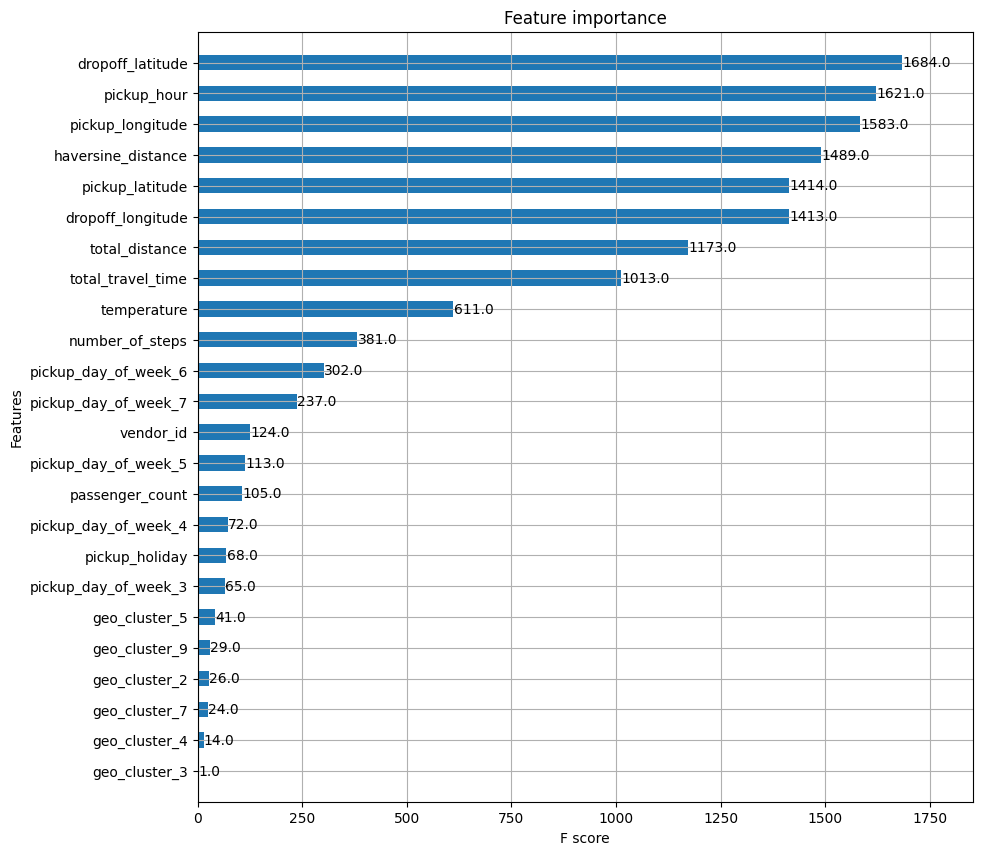

In [128]:
fig, ax_xgb = plt.subplots(figsize = (10, 10))
xgb.plot_importance(booster=XGB, ax=ax_xgb, height=0.5);

In [131]:
# прибираемся немного
del SKBst_selector_cols
del params_xgb, watchlist
del X_train_scaled, X_valid_scaled, X_test_scaled, y_train_log, y_valid_log
del dtrain, dvalid, dtest
del y_test_pred_xgb
del fig, ax_xgb
gc.collect();